In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [6]:
data = bd.bindome.datasets.SELEX.get_data()
# data[data['cycle'] == 'AF']
data

cardiac_complexes
# filenames 22
(22, 2)
PRJEB14744
# filenames 13
(13, 2)
PRJEB20112
# filenames 46
(46, 2)
PRJEB3289
# filenames 73
(73, 2)
PRJEB9797
# filenames 184
(184, 2)


filename       library batch cycle    tf.name  \
0        GATA4TBX5_R1_R46_016_999.txt.gz           R46   R46   R46  GATA4TBX5   
1        GATA4TBX5_R2_R46_033_999.txt.gz           R46   R46   R46  GATA4TBX5   
2        GATA4TBX5_R3_R46_051_999.txt.gz           R46   R46   R46  GATA4TBX5   
3            GATA4_R1_R46_032_777.txt.gz           R46   R46   R46      GATA4   
4            GATA4_R2_R46_046_777.txt.gz           R46   R46   R46      GATA4   
..                                   ...           ...   ...   ...        ...   
332  FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     2      FOXA1   
333  FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     3      FOXA1   
334  FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     3      FOXA1   
335  FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     4      FOXA1   
336  FOXA1_FL_4_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     4      FOXA1   

             accession                                               path  
0    cardiac_complexes  annotations/selex/cardiac_complexes/GATA4TBX5_...  
1    cardiac_complexes  annotations/selex/cardiac_complexes/GATA4TBX5_...  
2    cardiac_complexes  annotations/selex/cardiac_complexes/GATA4TBX5_...  
3    cardiac_complexes  annotations/selex/cardiac_complexes/GATA4_R1_R...  
4    cardiac_complexes  annotations/selex/cardiac_complexes/GATA4_R2_R...  
..                 ...                                                ...  
332          PRJEB9797  annotations/selex/PRJEB9797/FOXA1_FL_2_KX_TCCC...  
333          PRJEB9797  annotations/selex/PRJEB9797/FOXA1_FL_3_KX_TAGC...  
334          PRJEB9797  annotations/selex/PRJEB9797/FOXA1_FL_3_KX_TCCC...  
335          PRJEB9797  annotations/selex/PRJEB9797/FOXA1_FL_4_KX_TAGC...  
336          PRJEB9797  annotations/selex/PRJEB9797/FOXA1_FL_4_KX_TCCC...  

[337 rows x 7 columns]

In [10]:
writer = open('gene_names.txt', 'w')
for s in set(data['tf.name']):
    writer.write(s + '\n')
writer.close()

In [ ]:
data[data['accession'] == 'PRJEB20112']

In [37]:
data[(data['library'] == 'TAGCGT40NTCA') & ((data['cycle'] == 0) & data['library'].isin(set(data[data['tf.name'] == 'FOXA1']['library'])))]

filename       library batch cycle    tf.name  \
78  ZeroCycle_TAGCGT40NTCA_0_0.fastq.gz  TAGCGT40NTCA     0     0  ZEROCYCLE   

     accession  
78  PRJEB20112

In [38]:
set(data['tf.name'])

{'ALX1', 'ALX4', 'EGR1', 'ETS1', 'FOXA1', 'ZEROCYCLE'}

All TF's, using subsets of only round 0 and 1

In [5]:
model_by_k = {}
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    print(tf)
    
    for library, grp in data.groupby('library'):
        data_sel_tf = grp[(grp['tf.name'] == tf) & (grp['cycle'] == '1')]
        if data_sel_tf.shape[0] == 0:
            continue

        print('loading', tf, ':', library)
        reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
        data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
        reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)
        
        print(reads_tf.keys())
        print(reads_zero.keys())
        
        for k_tf in reads_tf:
            for k_r0 in reads_zero:
                print(k_r0, k_tf)
                
                k_model = tf + ':' + k_r0 + ':' + k_tf

                n_rounds = 1

                next_data = reads_zero[k_r0].merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
                new_cols = ['seq', k_r0, k_tf]
                next_data.columns = ['seq', k_r0, k_tf]
                for i, k in enumerate([k_r0, k_tf]):
                    next_data[k] = next_data[k].astype(int)
                    next_data[i] = next_data[k].astype(int)


                # next_data = next_data.head(10000)
                next_data = next_data.sample(n=10000)
                print(next_data.shape)
                
                print(next_data.head())
                
                # not needed for the current model, because the enrichment is not predicted
                # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])
                
                # assign batch and data type
                next_data['batch'] = 1
                next_data['is_count_data'] = 1

                dataset = mb.datasets.SelexDataset(next_data) # n_rounds=n_rounds)
                train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
                train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                
                
                ### steps to train model
                model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
                optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
                criterion = mb.tl.PoissonLoss()
                mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=5, log_each=11)
                
                # probably here load the state of the best epoch and save 
                model.load_state_dict(model.best_model_state)
                
                # store model parameters and fit for later visualization
                model_by_k[k_model] = model
                
                # assert False
                
                # stop (debugging)
                

FOXA1
loading FOXA1 : TAGCGT40NTCA
# uniq reads/total counts 191580/195771
# uniq reads/total counts 147714/148050
dict_keys(['FOXA1_FL_1_KX_TAGCGT40NTCA'])
dict_keys(['ZeroCycle_TAGCGT40NTCA_0_0'])
ZeroCycle_TAGCGT40NTCA_0_0 FOXA1_FL_1_KX_TAGCGT40NTCA
(10000, 5)
                                             seq  ZeroCycle_TAGCGT40NTCA_0_0  \
295892  CCCATGCTCGCAGCGATAACCGAAATCCCCCGTGACCCCG                           0   
20031   GTCCACCCATGCATGTTGGGCTGGTGGCGAACATAATGCG                           1   
256978  GAAGTAGCTAGACGGTCCTATCGGTTTCATGCCAACGCTG                           0   
128395  ACAATTGTCTATCTGACGCAGCCCGCGACTCCCGGTCCTC                           1   
235641  CCACCTAGTGTGTCGCGTCGCGGGGCCCCGCTTTTCGATC                           0   

        FOXA1_FL_1_KX_TAGCGT40NTCA  0  1  
295892                           1  0  1  
20031                            0  1  0  
256978                           1  0  1  
128395                           0  1  0  
235641                           1  0  1

In [18]:
data[data['tf.name'] == 'FOXA1']

filename       library batch cycle tf.name  \
29    FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     3   FOXA1   
31  FOXA1_eDBD_2_KN_TTCTAA40NAAT.fastq.gz  TTCTAA40NAAT  eDBD     2   FOXA1   
35  FOXA1_eDBD_4_KN_TCCCAA40NGAA.fastq.gz  TCCCAA40NGAA  eDBD     4   FOXA1   
37    FOXA1_FL_2_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     2   FOXA1   
38    FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     2   FOXA1   
46  FOXA1_eDBD_1_KN_TTCTAA40NAAT.fastq.gz  TTCTAA40NAAT  eDBD     1   FOXA1   
49  FOXA1_eDBD_1_KN_TCCCAA40NGAA.fastq.gz  TCCCAA40NGAA  eDBD     1   FOXA1   
51  FOXA1_eDBD_2_KN_TCCCAA40NGAA.fastq.gz  TCCCAA40NGAA  eDBD     2   FOXA1   
54    FOXA1_FL_4_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     4   FOXA1   
55    FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     4   FOXA1   
58  FOXA1_eDBD_4_KN_TTCTAA40NAAT.fastq.gz  TTCTAA40NAAT  eDBD     4   FOXA1   
60    FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     3   FOXA1   
63  FOXA1_eDBD_3_KN_TTCTAA40NAAT.fastq.gz  TTCTAA40NAAT  eDBD     3   FOXA1   
65    FOXA1_FL_1_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     1   FOXA1   
68    FOXA1_FL_1_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     1   FOXA1   
73  FOXA1_eDBD_3_KN_TCCCAA40NGAA.fastq.gz  TCCCAA40NGAA  eDBD     3   FOXA1   

    accession  
29  PRJEB9797  
31  PRJEB9797  
35  PRJEB9797  
37  PRJEB9797  
38  PRJEB9797  
46  PRJEB9797  
49  PRJEB9797  
51  PRJEB9797  
54  PRJEB9797  
55  PRJEB9797  
58  PRJEB9797  
60  PRJEB9797  
63  PRJEB9797  
65  PRJEB9797  
68  PRJEB9797  
73  PRJEB9797

FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_1_KX_TAGCGT40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


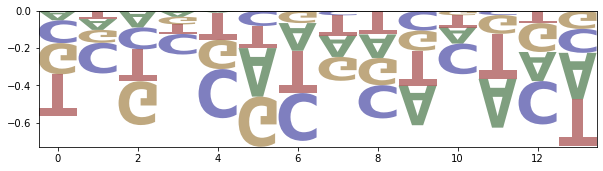

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


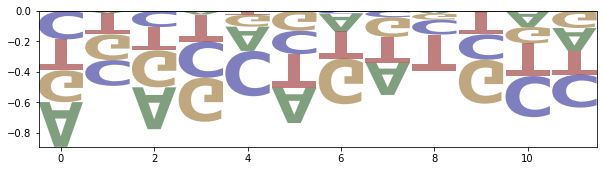


FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_1_KN_TCCCAA40NGAA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


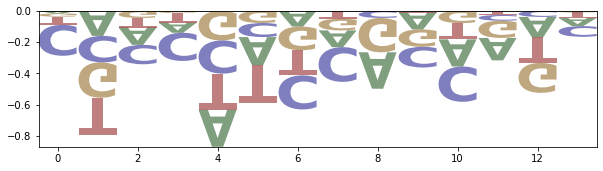

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


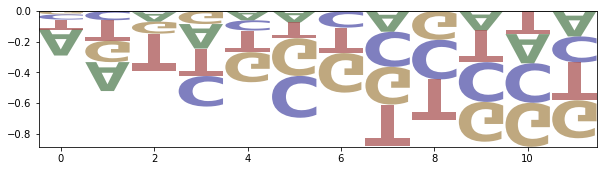


FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_1_KX_TCCCAT40NTGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


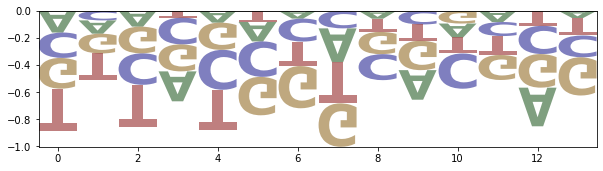

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


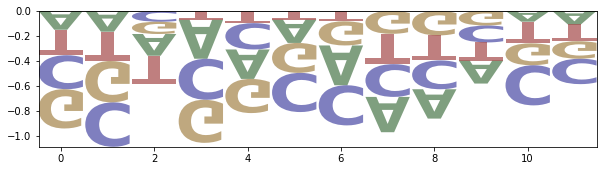


FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_1_KN_TTCTAA40NAAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


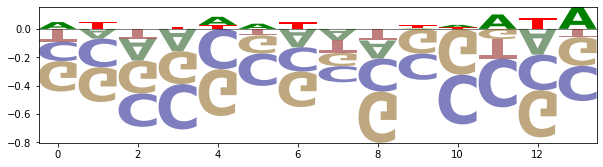

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


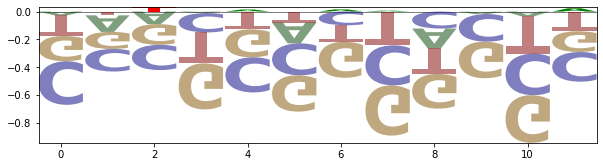


ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_1_KW_TCTATT40NCAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


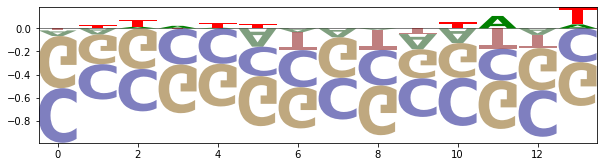

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


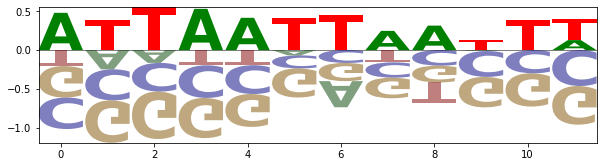


ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_1_KW_TGCGTA40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


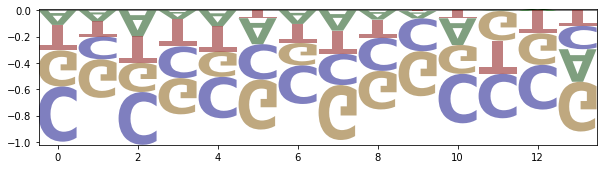

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


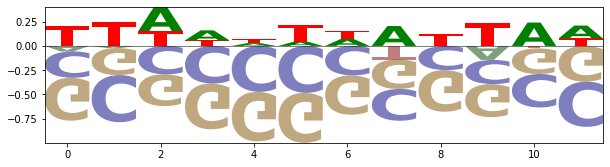


ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


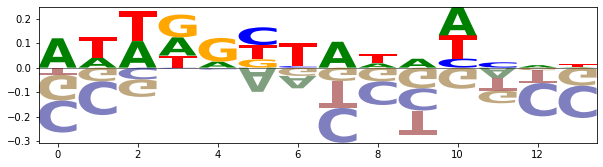

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


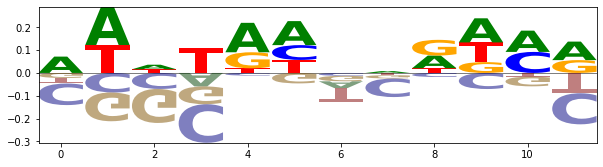


ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


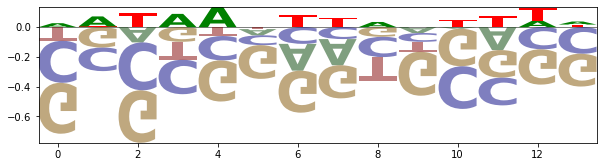

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


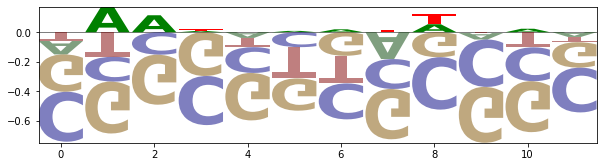


ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_1_KX_TACCAA40NTTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


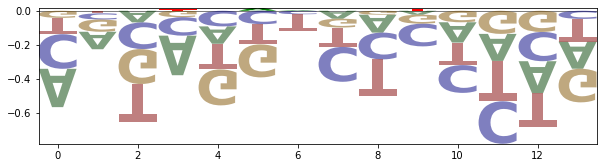

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


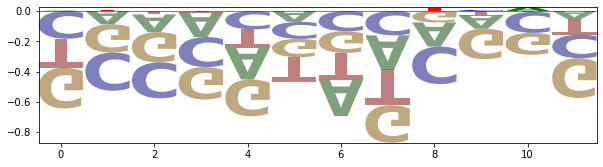


ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_1_KX_TCCTTG40NGGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


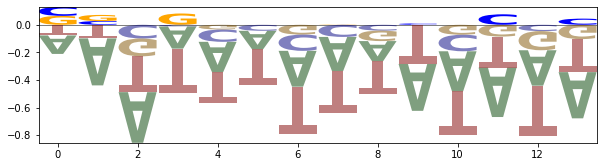

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


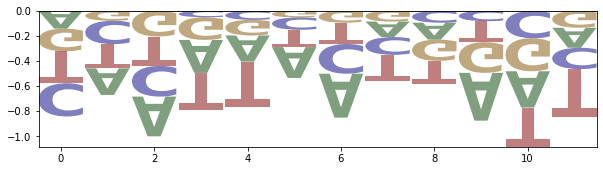


EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_1_KAN_TAGACA40NGTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


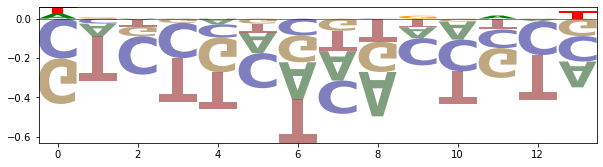

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


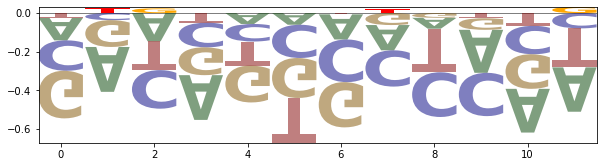


EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_1_KR_TCAGCC40NTTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


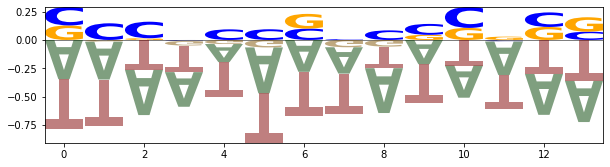

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


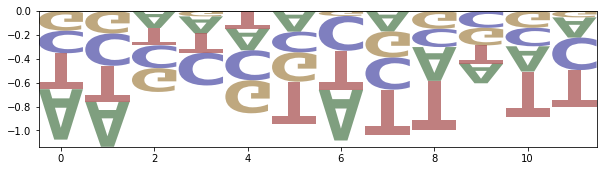


EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_1_KAN_TCCGCT40NGCG
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


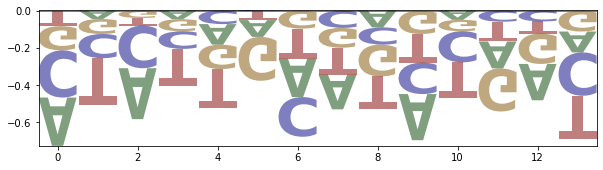

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


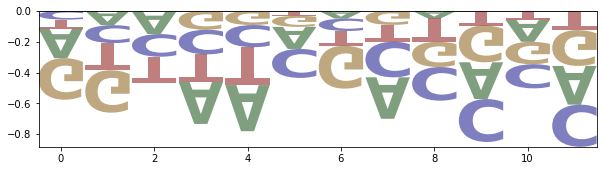


EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_1_KR_TTGTAC40NGTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


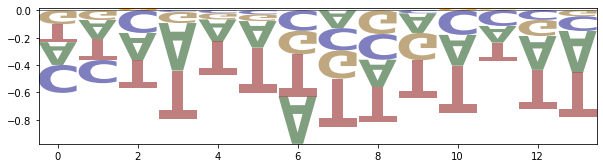

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


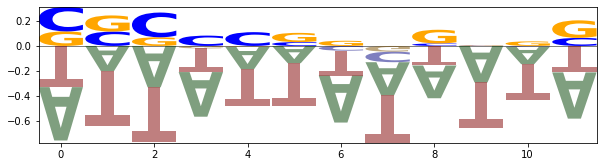


ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


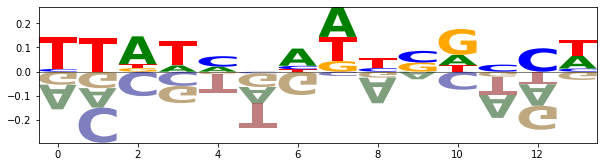

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


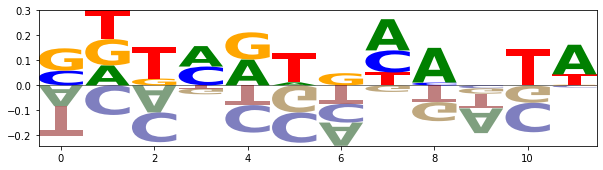


ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


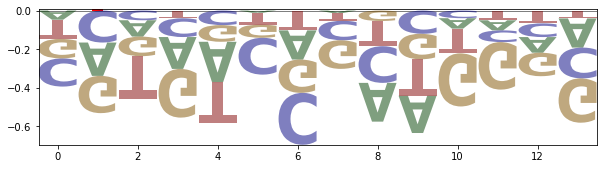

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


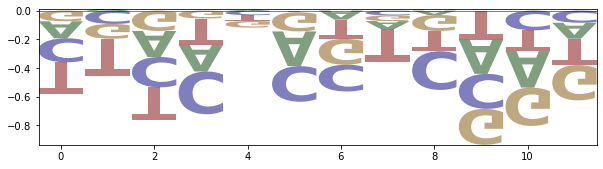


ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


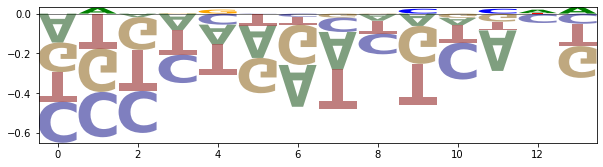

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


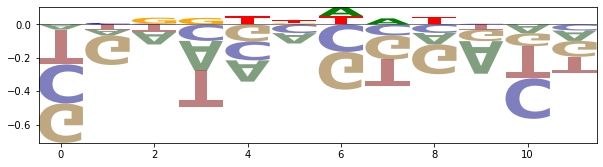


ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


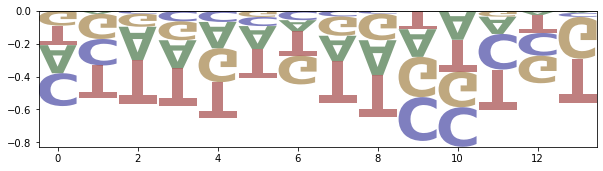

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


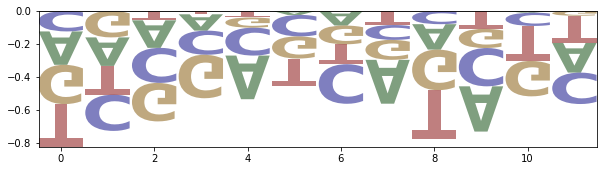

In [6]:
for k in model_by_k:
    print(k)
    model = model_by_k[k] 
    mb.pl.conv_mono(model)
    print('')

In [45]:
for k in model_by_k:
    print(k)

ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1
ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_3
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_3
ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_4
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_4
ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_2
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_2
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_2
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_2
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_4
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_4
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_3
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_3
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_6
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_6
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1
ETS1:Zer

ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


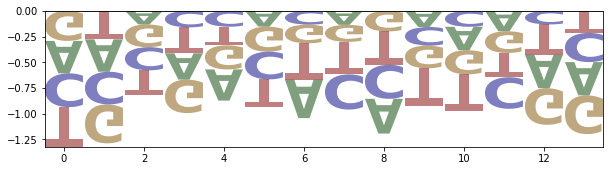

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


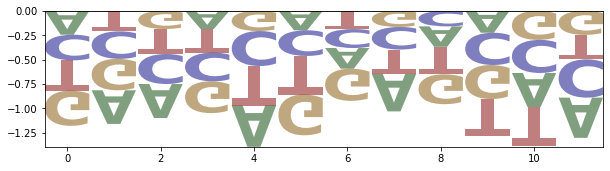


ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


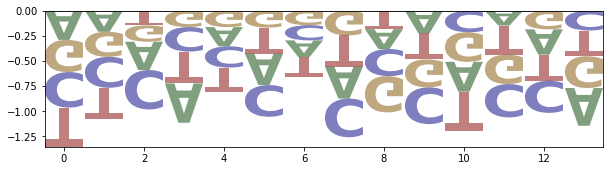

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


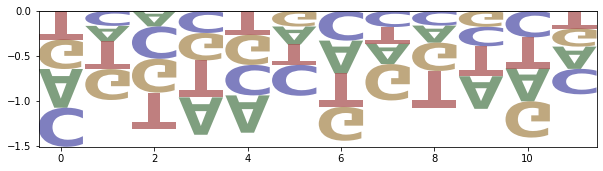


ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


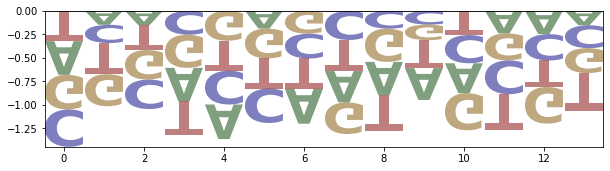

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


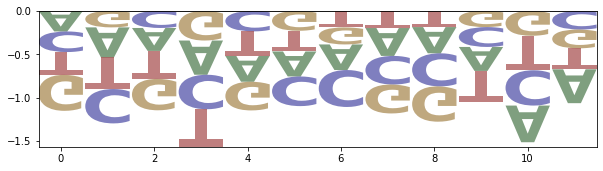


ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


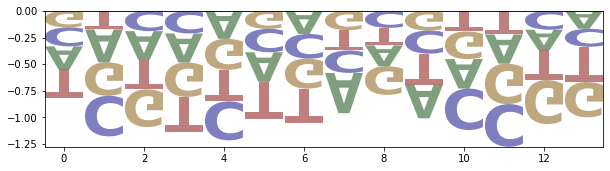

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


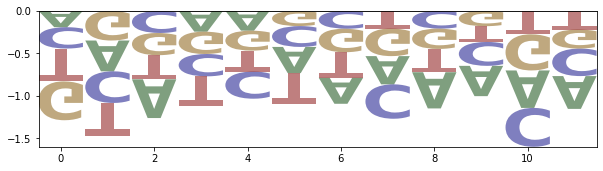


FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_1_KX_TAGCGT40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


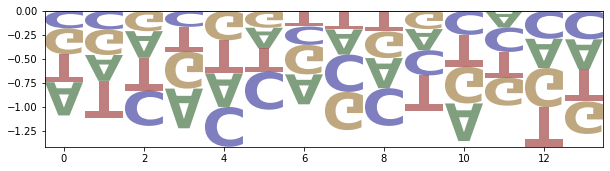

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


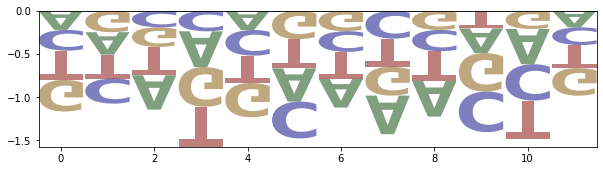


FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_1_KN_TCCCAA40NGAA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


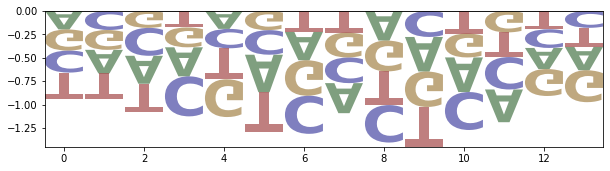

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


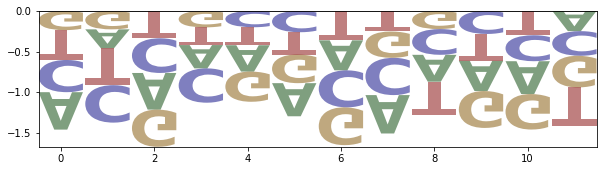


FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_1_KX_TCCCAT40NTGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


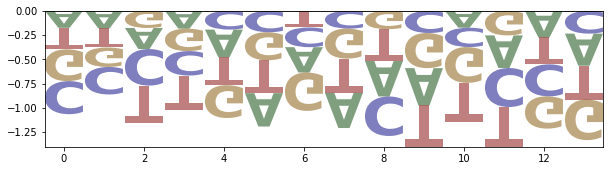

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


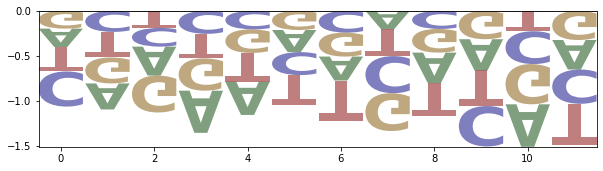


FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_1_KN_TTCTAA40NAAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


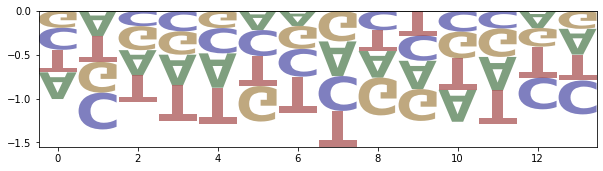

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


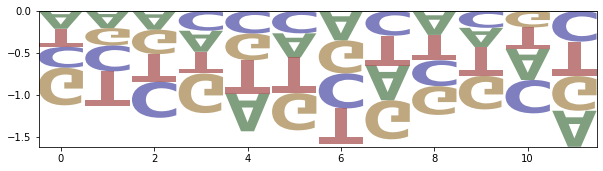


ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_1_KW_TCTATT40NCAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


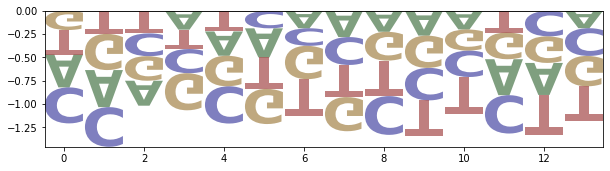

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


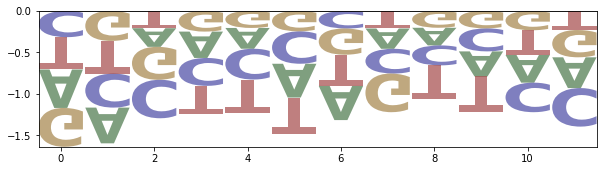


ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_1_KW_TGCGTA40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


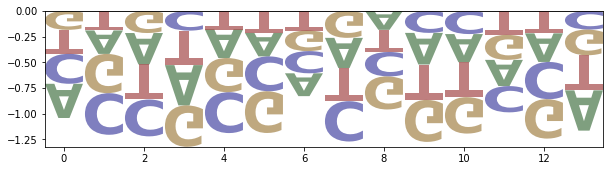

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


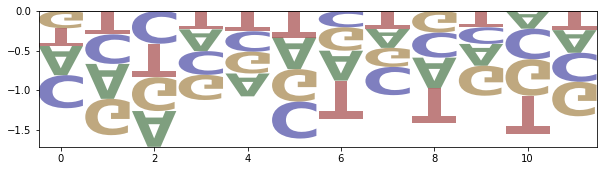


ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


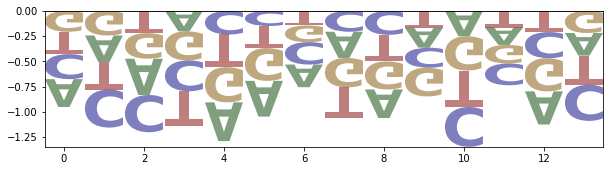

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


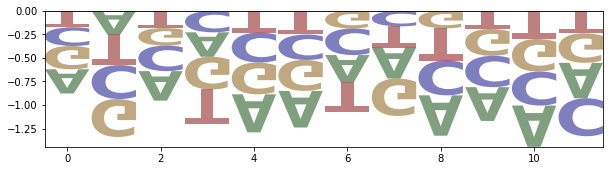


ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


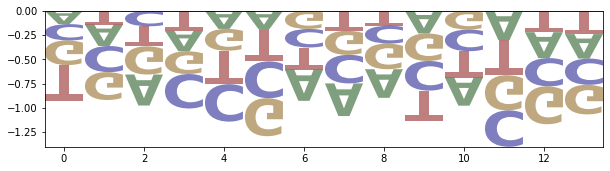

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


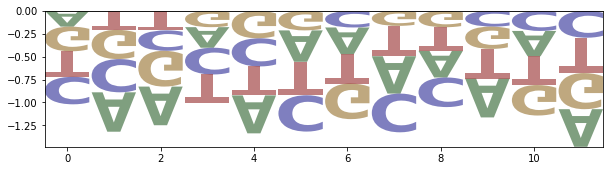


ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_1_KX_TACCAA40NTTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


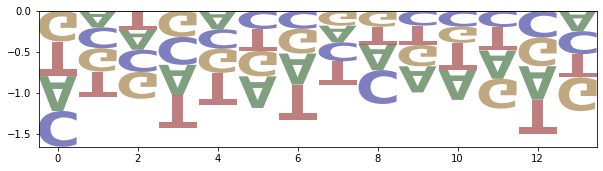

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


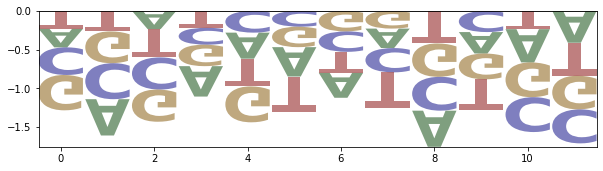


ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_1_KX_TCCTTG40NGGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


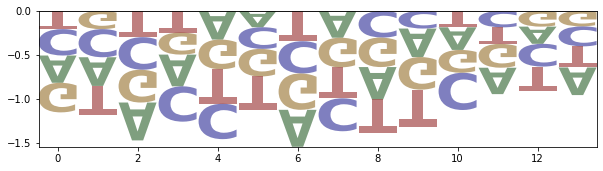

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


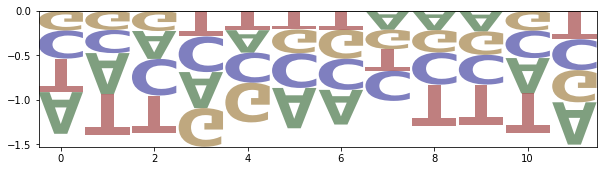


EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_1_KAN_TAGACA40NGTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


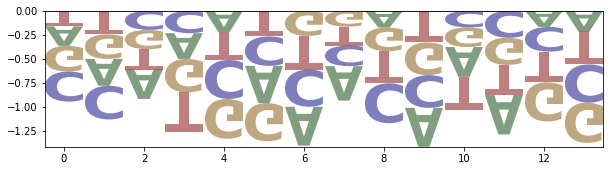

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


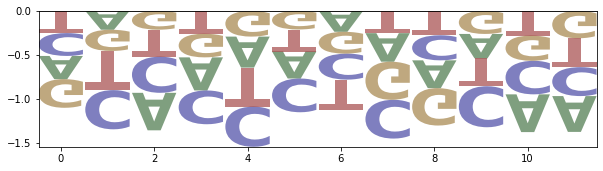


EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_1_KR_TCAGCC40NTTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


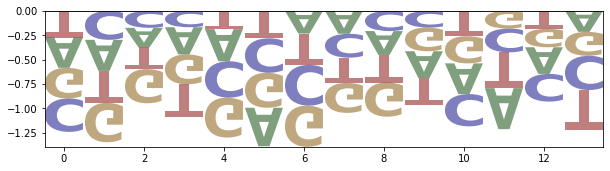

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


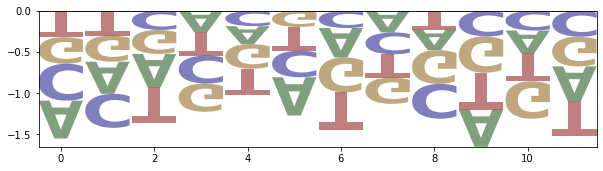


EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_1_KAN_TCCGCT40NGCG
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


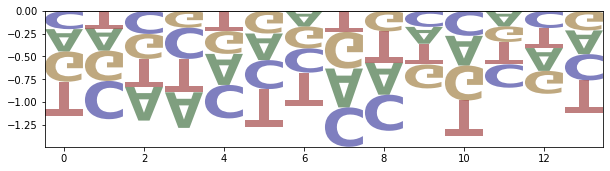

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


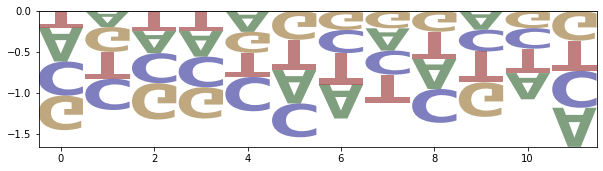


EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_1_KR_TTGTAC40NGTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


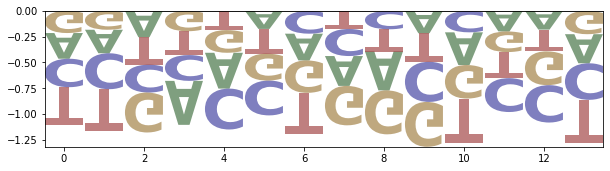

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


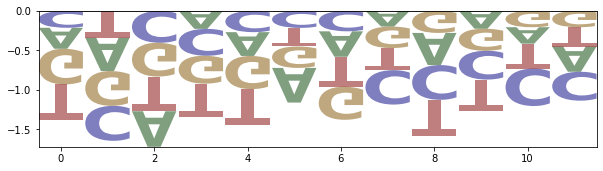

In [47]:
model_selection = ['ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1', 'ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1', 'ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1', 'ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1', 'FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_1_KX_TAGCGT40NTCA', 'FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_1_KN_TCCCAA40NGAA', 'FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_1_KX_TCCCAT40NTGT', 'FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_1_KN_TTCTAA40NAAT', 'ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_1_KW_TCTATT40NCAT', 'ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_1_KW_TGCGTA40NTCA', 'ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_1', 'ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_1', 'ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_1_KX_TACCAA40NTTA', 'ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_1_KX_TCCTTG40NGGT', 'EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_1_KAN_TAGACA40NGTC', 'EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_1_KR_TCAGCC40NTTC', 'EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_1_KAN_TCCGCT40NGCG', 'EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_1_KR_TTGTAC40NGTA']
for k in model_selection:
    print(k)
    model = model_by_k[k] 
    mb.pl.conv_mono(model)
    print('')

In [50]:
data[(data['tf.name'] == 'ETS1') & (data['library'] == 'TGTAAA20NGA')]

filename      library batch cycle tf.name  accession
8   ETS1_TGTAAA20NGA_AF_1.fastq.gz  TGTAAA20NGA    AF     1    ETS1  PRJEB3289
13  ETS1_TGTAAA20NGA_AF_3.fastq.gz  TGTAAA20NGA    AF     3    ETS1  PRJEB3289
16  ETS1_TGTAAA20NGA_AF_4.fastq.gz  TGTAAA20NGA    AF     4    ETS1  PRJEB3289
22  ETS1_TGTAAA20NGA_AF_2.fastq.gz  TGTAAA20NGA    AF     2    ETS1  PRJEB3289

ETS1, using the full r0 and r1 data of one library:

In [83]:
# model_by_k = {}
tf = 'ETS1'
library = 'TGTAAA20NGA'
grp = data[data['library'] == 'TGTAAA20NGA']

data_sel_tf = grp[grp['tf.name'] == tf]
data_sel_tf = data_sel_tf[data_sel_tf['cycle'] == '1']

print('loading', tf, ':', library)
reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
data_sel_zero = data_sel_zero[data_sel_zero['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz']
reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)

print(reads_tf.keys())
print(reads_zero.keys())

for k_tf in reads_tf:
    for k_r0 in reads_zero:
        print(k_r0, k_tf)

        k_model = tf + ':' + k_r0 + ':' + k_tf

        n_rounds = 1

        next_data = reads_zero[k_r0].merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
        new_cols = ['seq', k_r0, k_tf]
        next_data.columns = ['seq', k_r0, k_tf]
        for i, k in enumerate([k_r0, k_tf]):
            next_data[k] = next_data[k].astype(int)
            next_data[i] = next_data[k].astype(int)


        # next_data = next_data.sample(n=10000)
        print(next_data.shape)

        print(next_data.head())

        # not needed for the current model, because the enrichment is not predicted
        # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

        # assign batch and data type
        next_data['batch'] = 1
        next_data['is_count_data'] = 1

        dataset = mb.datasets.SelexDataset(next_data) # n_rounds=n_rounds)
        train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
        train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

        ### steps to train model
        model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
        optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = mb.tl.PoissonLoss()
        mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=-1, log_each=1)

        # probably here load the state of the best epoch and save 
        model.load_state_dict(model.best_model_state)

        # store model parameters and fit for later visualization
        # model_by_k[k_model] = model

        # assert False

        # stop (debugging)


loading ETS1 : TGTAAA20NGA
# uniq reads/total counts 178944/180855
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1'])
dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0'])
ZeroCycle_ES0_TGTAAA20NGA_0 ETS1_TGTAAA20NGA_AF_1
(407295, 5)
                    seq  ZeroCycle_ES0_TGTAAA20NGA_0  ETS1_TGTAAA20NGA_AF_1  \
0  GGACCTTACCGTTATACGCC                            2                      0   
1  TCATATCCCAACTCACGAGC                            2                      0   
2  TCATGCATACCTTAATGGTC                            2                      0   
3  ACCTGCTGACCGTATAGGAG                            2                      0   
4  TATACTTCCAACTCACGGCC                            2                      0   

   0  1  
0  2  0  
1  2  0  
2  2  0  
3  2  0  
4  2  0  
Epoch:  1, Loss: 0.862
Epoch:  2, Loss: 0.842
Epoch:  3, Loss: 0.842
Epoch:  4, Loss: 0.842
Epoch:  5, Loss: 0.841
Epoch:  6, Loss: 0.841
Epoch:  7, Loss: 0.841
Epoch:  8, Loss: 0.841
Epoch:  9, Loss: 0.841
Epoch: 10

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


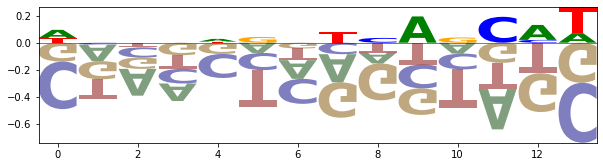

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


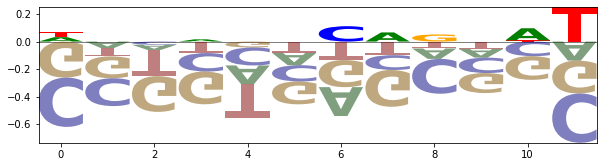

In [84]:
mb.pl.conv_mono(model)

seq  ZeroCycle_TGTAAA20NGA_0_0  ETS1_TGTAAA20NGA_AF_1   0  \
0  TCGTATGCCGTCTTCTGCTT                         10                    135  10   

     1  batch  is_count_data  
0  135      1              1

In [85]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device)
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None

    inputs = (mononuc, mononuc_rev, dinuc, dinuc_rev, b, seqlen, torch.sum(rounds, axis=1))
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())
    if i >= 200:
        break

In [86]:
all_outputs

[array([1.1288553 , 0.87114465], dtype=float32),
 array([1.165779  , 0.83422107], dtype=float32),
 array([1.0370189 , 0.96298105], dtype=float32),
 array([1.1396528, 0.8603472], dtype=float32),
 array([1.1407241 , 0.85927594], dtype=float32),
 array([1.1888554, 0.8111447], dtype=float32),
 array([1.2012691, 0.7987308], dtype=float32),
 array([1.220229, 0.779771], dtype=float32),
 array([1.0233854 , 0.97661453], dtype=float32),
 array([1.2147138 , 0.78528625], dtype=float32),
 array([1.2240547 , 0.77594537], dtype=float32),
 array([1.2179208 , 0.78207916], dtype=float32),
 array([1.0691836 , 0.93081635], dtype=float32),
 array([1.1262522, 0.8737478], dtype=float32),
 array([1.1984241, 0.8015758], dtype=float32),
 array([1.0537881, 0.946212 ], dtype=float32),
 array([1.1950281, 0.8049718], dtype=float32),
 array([1.0765917, 0.9234082], dtype=float32),
 array([1.0871614 , 0.91283846], dtype=float32),
 array([1.2492644, 0.7507356], dtype=float32),
 array([0.9659248, 1.0340751], dtype=float

ETS1, using only a subset of the r0 and r1 data (very many epochs)

In [93]:
# model_by_k = {}
tf = 'ETS1'
library = 'TGTAAA20NGA'
grp = data[data['library'] == 'TGTAAA20NGA']

data_sel_tf = grp[grp['tf.name'] == tf]
data_sel_tf = data_sel_tf[data_sel_tf['cycle'] == '1']

print('loading', tf, ':', library)
reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
data_sel_zero = data_sel_zero[data_sel_zero['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz']
reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)

print(reads_tf.keys())
print(reads_zero.keys())

for k_tf in reads_tf:
    for k_r0 in reads_zero:
        print(k_r0, k_tf)

        k_model = tf + ':' + k_r0 + ':' + k_tf

        n_rounds = 1

        next_data = reads_zero[k_r0].merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
        new_cols = ['seq', k_r0, k_tf]
        next_data.columns = ['seq', k_r0, k_tf]
        for i, k in enumerate([k_r0, k_tf]):
            next_data[k] = next_data[k].astype(int)
            next_data[i] = next_data[k].astype(int)


        next_data = next_data.sample(n=1000)
        print(next_data.shape)

        print(next_data.head())

        # not needed for the current model, because the enrichment is not predicted
        # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

        # assign batch and data type
        next_data['batch'] = 1
        next_data['is_count_data'] = 1

        dataset = mb.datasets.SelexDataset(next_data) # n_rounds=n_rounds)
        train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
        train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

        ### steps to train model
        model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
        optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = mb.tl.PoissonLoss()
        mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10000, early_stopping=-1, log_each=100)

        # probably here load the state of the best epoch and save 
        model.load_state_dict(model.best_model_state)

        # store model parameters and fit for later visualization
        # model_by_k[k_model] = model

        # assert False

        # stop (debugging)


loading ETS1 : TGTAAA20NGA
# uniq reads/total counts 178944/180855
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1'])
dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0'])
ZeroCycle_ES0_TGTAAA20NGA_0 ETS1_TGTAAA20NGA_AF_1
(1000, 5)
                         seq  ZeroCycle_ES0_TGTAAA20NGA_0  \
356705  ACACACTAACGCCACATTGC                            0   
346616  GTTCCACGCATCCTCCCAAC                            0   
329747  CCGCATGAACAACCACGTTG                            0   
55764   CACACCAGCTATACCCTATT                            1   
228237  CTGAGTGAACCACGGTGACT                            1   

        ETS1_TGTAAA20NGA_AF_1  0  1  
356705                      1  0  1  
346616                      1  0  1  
329747                      1  0  1  
55764                       0  1  0  
228237                      0  1  0  
Epoch:  1, Loss: 1.249
Epoch: 101, Loss: 0.844
Epoch: 201, Loss: 0.843
Epoch: 301, Loss: 0.842
Epoch: 401, Loss: 0.840
Epoch: 501, Loss: 0.838
Epoch: 601, Los

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


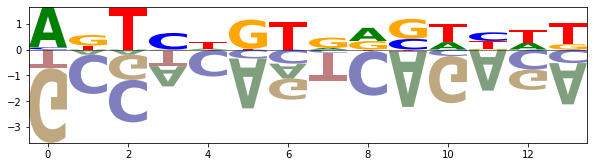

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


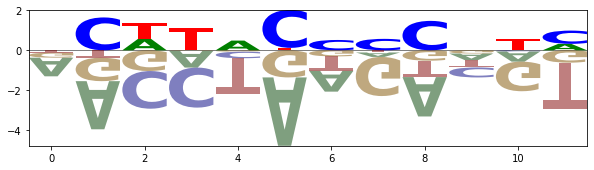

In [94]:
mb.pl.conv_mono(model)

In [95]:
print(model.log_activity.weight)

Parameter containing:
tensor([[ 2.7356e-05, -8.3618e-02],
        [-6.7003e-06, -2.9363e-01],
        [ 1.6522e-05, -5.8203e-01]], requires_grad=True)


In [96]:
print(model.log_eta.weight)

Parameter containing:
tensor([[ 0.4173],
        [-0.4173]], requires_grad=True)


ETS1, fitting to all rounds of one library (full dataset)

In [9]:
# model_by_k = {}
tf = 'ETS1'
library = 'TGTAAA20NGA'
grp = data[data['library'] == 'TGTAAA20NGA']

data_sel_tf = grp[grp['tf.name'] == tf]
# data_sel_tf = data_sel_tf[data_sel_tf['cycle'] == '1']

print('loading', tf, ':', library)
reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
data_sel_zero = data_sel_zero[data_sel_zero['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz']
reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)

print(reads_tf.keys())
print(reads_zero.keys())

# model over all 4 rounds

k_r0 = list(reads_zero.keys())[0]
next_data = reads_zero[k_r0]
for k_tf in reads_tf:
    next_data = next_data.merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)

n_rounds = 4
next_data.columns = ['seq', 0, 1, 2, 3, 4]
for i, k in enumerate([0, 1, 2, 3, 4]):
    next_data[k] = next_data[k].astype(int)

# next_data = next_data.sample(n=1000)
print(next_data.shape)

print(next_data.head())

# not needed for the current model, because the enrichment is not predicted
# next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

# assign batch and data type
# next_data['batch'] = 1
# next_data['is_count_data'] = 1

dataset = mb.datasets.SelexDataset(next_data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

### steps to train model
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=n_rounds).to(device)
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=-1, log_each=1)

# probably here load the state of the best epoch and save 
model.load_state_dict(model.best_model_state)

# store model parameters and fit for later visualization
# model_by_k[k_model] = model

# assert False

# stop (debugging)


loading ETS1 : TGTAAA20NGA
# uniq reads/total counts 178944/180855
# uniq reads/total counts 172559/230033
# uniq reads/total counts 42327/94179
# uniq reads/total counts 174479/179246
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1', 'ETS1_TGTAAA20NGA_AF_3', 'ETS1_TGTAAA20NGA_AF_4', 'ETS1_TGTAAA20NGA_AF_2'])
dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0'])
(772868, 6)
                    seq  0  1  2  3  4
0  TCCGTGGCTGCCCACGTGCC  2  0  0  0  0
1  TCATGCATACCTTAATGGTC  2  0  0  0  0
2  TAATGCCTCGCCACGCGCGG  2  0  0  0  0
3  AATAAGGACGACTGCAGCGC  2  0  0  0  0
4  CGTGTAAAGGCACGTCCCGA  2  0  0  0  0
Epoch:  1, Loss: 0.472
Epoch:  2, Loss: 0.445
Epoch:  3, Loss: 0.444
Epoch:  4, Loss: 0.442
Epoch:  5, Loss: 0.441
Epoch:  6, Loss: 0.441
Epoch:  7, Loss: 0.440
Epoch:  8, Loss: 0.439
Epoch:  9, Loss: 0.438
Epoch: 10, Loss: 0.438


<All keys matched successfully>

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


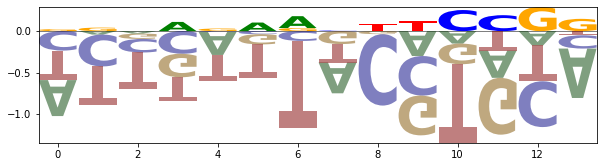

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


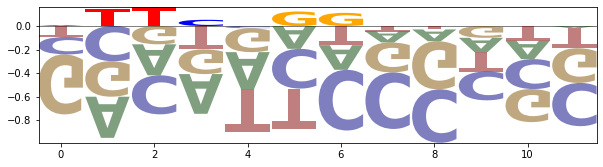

In [10]:
mb.pl.conv_mono(model)

In [11]:
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=-1, log_each=1)
model.load_state_dict(model.best_model_state)

Epoch:  1, Loss: 0.438
Epoch:  2, Loss: 0.437
Epoch:  3, Loss: 0.437
Epoch:  4, Loss: 0.437
Epoch:  5, Loss: 0.437
Epoch:  6, Loss: 0.437
Epoch:  7, Loss: 0.437
Epoch:  8, Loss: 0.436
Epoch:  9, Loss: 0.436
Epoch: 10, Loss: 0.436


<All keys matched successfully>

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


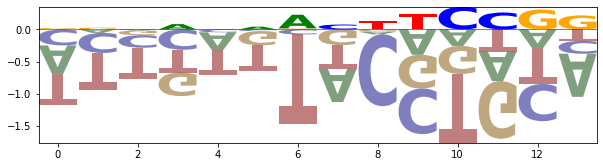

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


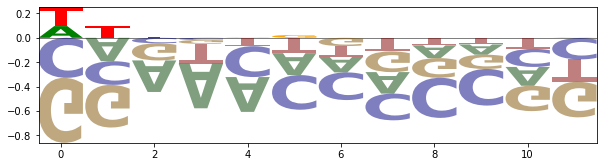

In [12]:
mb.pl.conv_mono(model)

All TF's, using subsets of round 0 and 2

In [14]:
model2_by_k = {}
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    print(tf)
    
    for library, grp in data.groupby('library'):
        data_sel_tf = grp[(grp['tf.name'] == tf) & (grp['cycle'] == '2')]
        if data_sel_tf.shape[0] == 0:
            continue

        print('loading', tf, ':', library)
        reads_tf2 = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
        data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
        reads_zero2 = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)
        
        print(reads_tf2.keys())
        print(reads_zero2.keys())
        
        for k_tf in reads_tf2:
            for k_r0 in reads_zero2:
                print(k_r0, k_tf)
                
                k_model = tf + ':' + k_r0 + ':' + k_tf

                n_rounds = 1

                next_data2 = reads_zero2[k_r0].merge(reads_tf2[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
                new_cols2 = ['seq', k_r0, k_tf]
                next_data2.columns = ['seq', k_r0, k_tf]
                for i, k in enumerate([k_r0, k_tf]):
                    next_data2[k] = next_data2[k].astype(int)
                    next_data2[i] = next_data2[k].astype(int)


                # next_data = next_data.head(10000)
                next_data2 = next_data2.sample(n=10000)
                print(next_data2.shape)
                
                print(next_data2.head())
                
                # not needed for the current model, because the enrichment is not predicted
                # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])
                
                # assign batch and data type
                #next_data2['batch'] = 1
                #next_data2['is_count_data'] = 1

                dataset2 = mb.datasets.SelexDataset(next_data2) # n_rounds=n_rounds)
                train2 = tdata.DataLoader(dataset=dataset2, batch_size=256, shuffle=True)
                train_test2 = tdata.DataLoader(dataset=dataset2, batch_size=1, shuffle=False)                
                
                ### steps to train model
                model2 = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
                optimiser2 = topti.Adam(model2.parameters(), lr=0.001, weight_decay=0.0001)
                criterion = mb.tl.PoissonLoss()
                mb.tl.train_network(model2, train2, device, optimiser2, criterion, num_epochs=200, early_stopping=5, log_each=11)
                
                # probably here load the state of the best epoch and save 
                model2.load_state_dict(model2.best_model_state)
                
                # store model parameters and fit for later visualization
                model2_by_k[k_model] = model2
                
                # assert False
                
                # stop (debugging)
                

FOXA1
loading FOXA1 : TAGCGT40NTCA
# uniq reads/total counts 160291/165113
# uniq reads/total counts 147714/148050
dict_keys(['FOXA1_FL_2_KX_TAGCGT40NTCA'])
dict_keys(['ZeroCycle_TAGCGT40NTCA_0_0'])
ZeroCycle_TAGCGT40NTCA_0_0 FOXA1_FL_2_KX_TAGCGT40NTCA
(10000, 5)
                                             seq  ZeroCycle_TAGCGT40NTCA_0_0  \
286507  GAACTTCGCACGCCCCGTTACCCGCACTTATGAATCCATG                           0   
302244  CAATGAACTCCCACCGACACCGTTAACCCAAATGCCCATT                           0   
302536  GCCCTCGCGTCAACAGTACGAGCTACGCCAACTCCCCGCA                           0   
120078  ATTGTGCTCCGGCCCTTCTTCCTCCTTACTGCTACACTAT                           1   
98930   CACCGCTAAGTCTGCCCTCCCATTCCTAGACTAGCCGGAT                           1   

        FOXA1_FL_2_KX_TAGCGT40NTCA  0  1  
286507                           1  0  1  
302244                           1  0  1  
302536                           1  0  1  
120078                           0  1  0  
98930                            0  1  0

FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_2_KX_TAGCGT40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


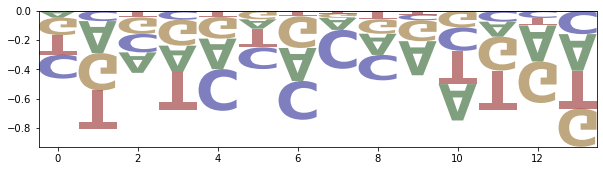

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


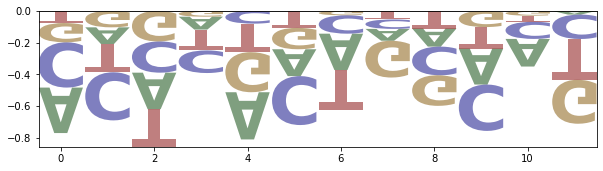


FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_2_KN_TCCCAA40NGAA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


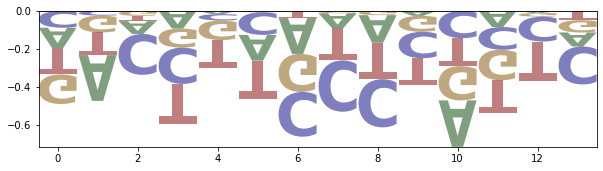

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


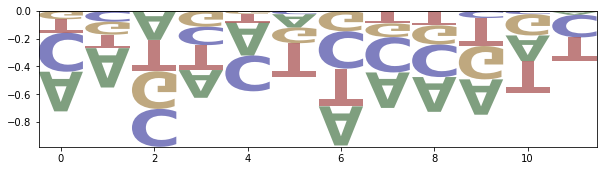


FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_2_KX_TCCCAT40NTGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


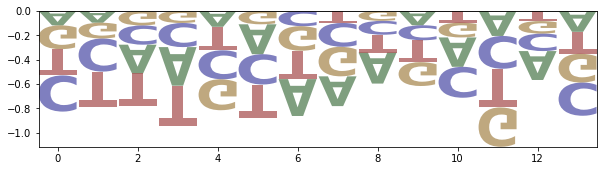

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


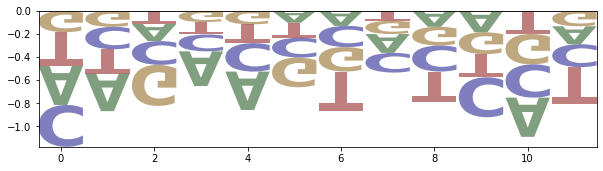


FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_2_KN_TTCTAA40NAAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


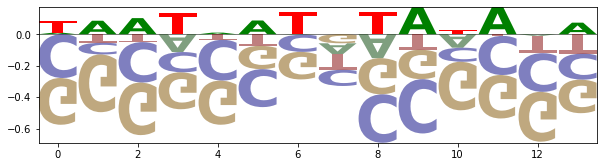

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


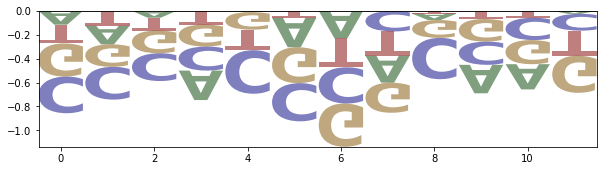


ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_2_KW_TCTATT40NCAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


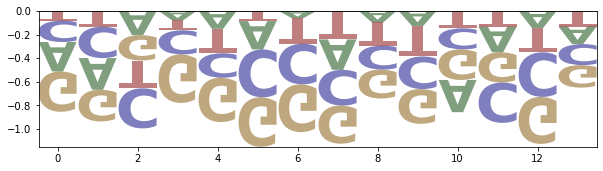

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


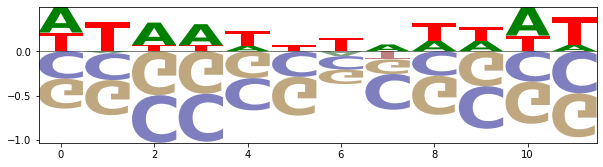


ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_2_KW_TGCGTA40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


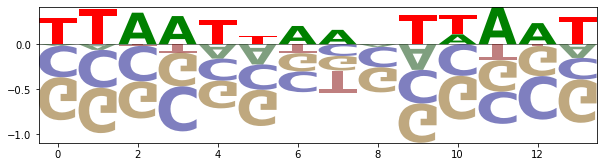

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


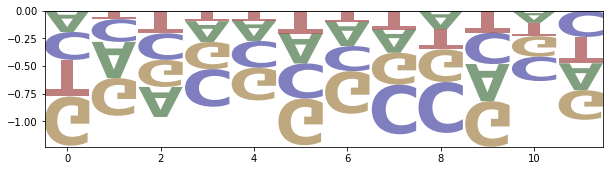


ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


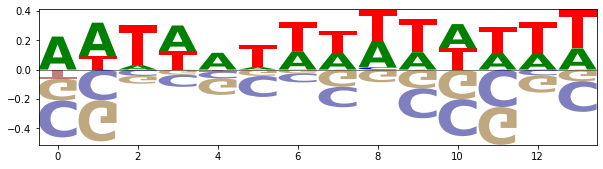

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


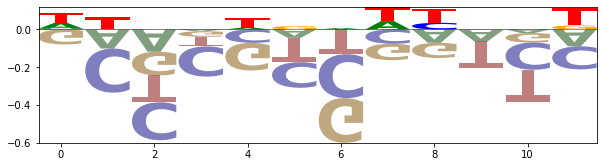


ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


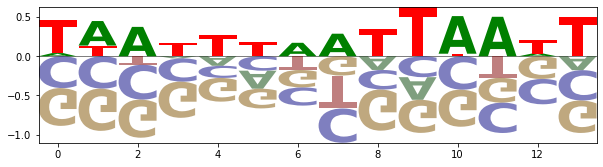

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


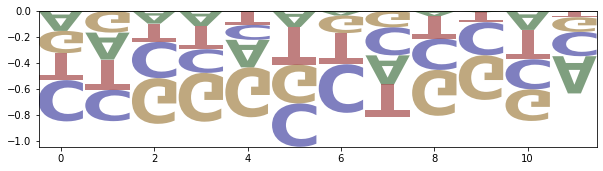


ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_2_KX_TACCAA40NTTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


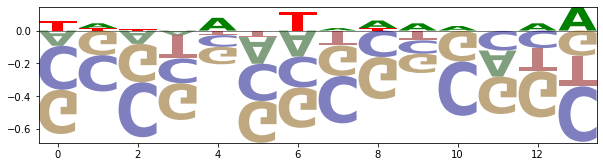

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


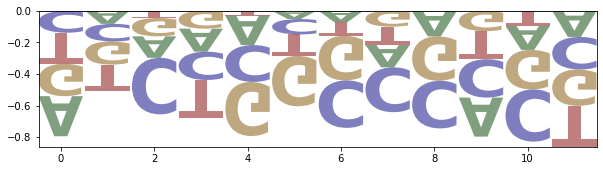


ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_2_KX_TCCTTG40NGGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


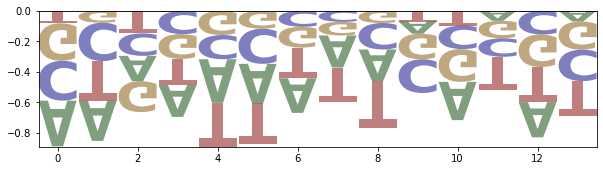

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


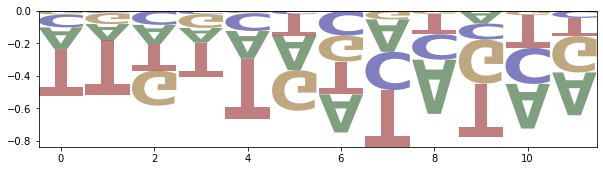


EGR1:ZeroCycle_TACTAT20NATC_0_0:EGR1_TACTAT20NATC_AA_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


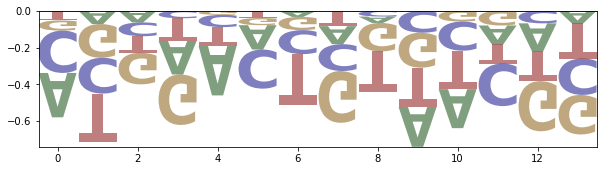

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


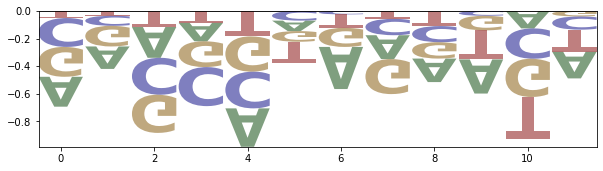


EGR1:ZeroCycle_ES0_TACTAT20NATC_0:EGR1_TACTAT20NATC_AA_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


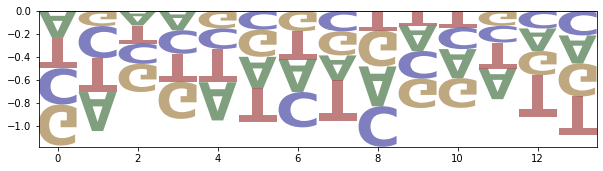

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


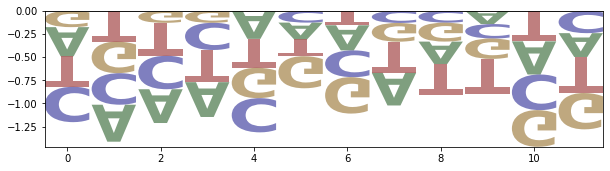


EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_2_KAN_TAGACA40NGTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


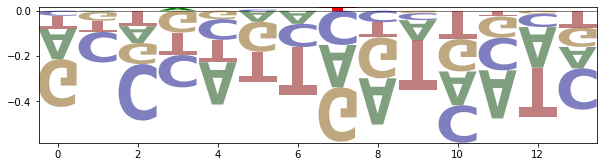

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


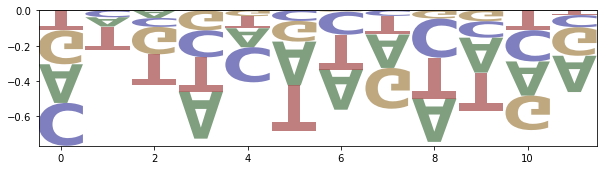


EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_2_KR_TCAGCC40NTTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


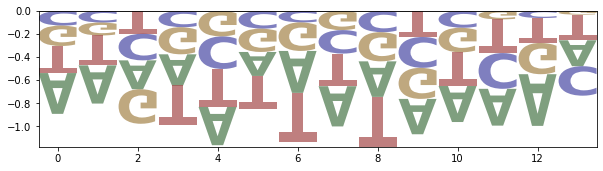

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


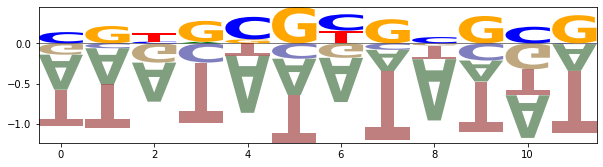


EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_2_KAN_TCCGCT40NGCG
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


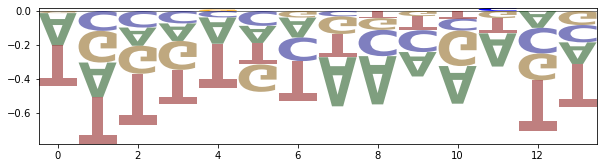

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


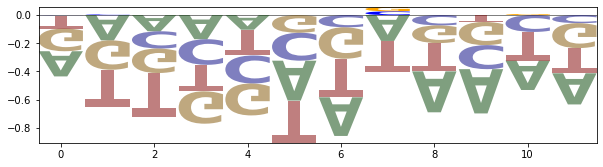


EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_2_KR_TTGTAC40NGTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


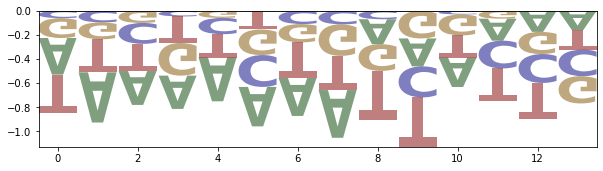

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


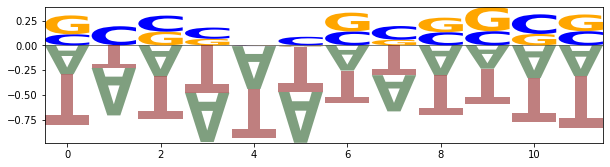


ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


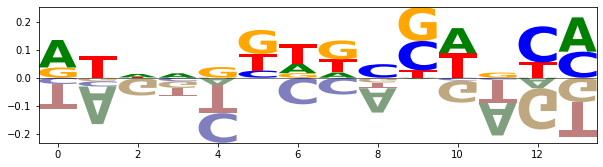

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


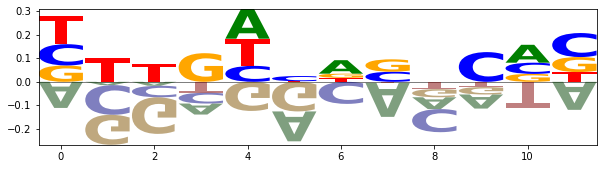


ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


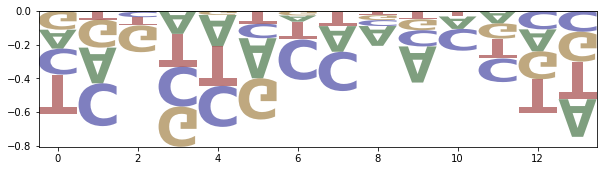

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


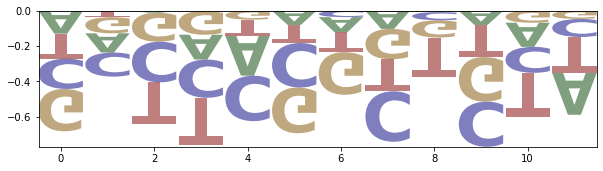


ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


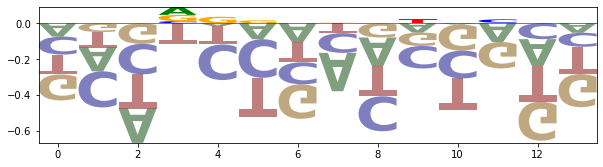

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


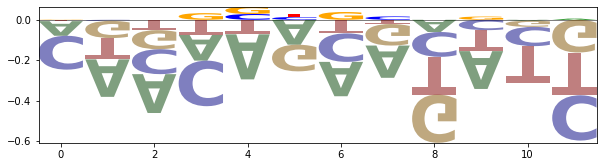


ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


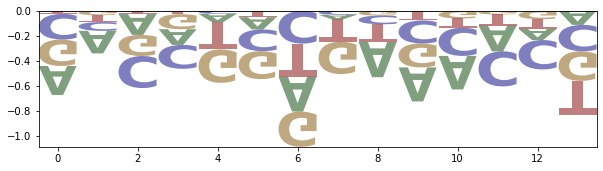

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


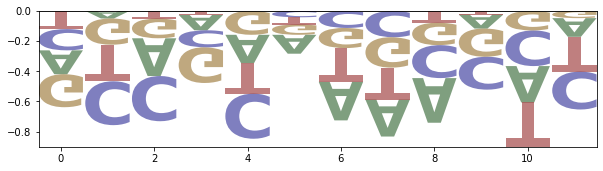

In [15]:
for k in model2_by_k:
    print(k)
    model2 = model2_by_k[k] 
    mb.pl.conv_mono(model2)
    print('')

In [19]:
#training the ETS1 model over all rounds for one more epoch in order to test get_last_loss_value()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=1, early_stopping=-1, log_each=1)

Epoch:  1, Loss: 0.436


[0.43597027683038486]

In [20]:
mb.tl.get_last_loss_value()

0.43597027683038486